### Simple Multi-AI agent

In [43]:
import os
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
import os
from dotenv import load_dotenv

load_dotenv()

google_api_key = os.getenv("GOOGLE_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

os.environ["GOOGLE_API_KEY"] = google_api_key
os.environ["TAVILY_API_KEY"] = tavily_api_key 

langsmith_api_key = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_API_KEY"] = langsmith_api_key
os.environ["LANGSMITH_TRACING"] = "true" 
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm

E0000 00:00:1760432611.220445   21007 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7f31abfe24b0>, default_metadata=(), model_kwargs={})

In [44]:
class AgentState(MessagesState):
    next_agent:str #which agent should go next 

In [45]:
@tool
def search_web(query: str)-> str:
    """Search the web for information"""
    search = TavilySearch(max_results=2)
    results = search.invoke(query)
    return str(results)

@tool 
def write_summary(content: str) -> str:
    """Write a concise summary of the content"""
    summary = f"Summary: {content[:500]}..."  # Simple placeholder summary
    return summary

In [46]:
def researcher_agent(state: AgentState):
    """Researcher agent that searches for information"""
    messages = state["messages"]
    
    # Add system message for context (not wrapped in list)
    system_msg = SystemMessage(content="You are a research assistant. Use the search_web tool to find information about the user's request.")
    
    # Call LLM with tools
    researcher_llm = llm.bind_tools([search_web])
    response = researcher_llm.invoke([system_msg] + messages)
    
    return {
        "messages": [response],
        "next_agent": "writer"
    }

In [47]:
def writer_agent(state: AgentState):
    """Writer agent that creates summaries"""
    messages = state["messages"]
    
    # Add system message (not wrapped in list)
    system_msg = SystemMessage(content="You are a technical writer. Review the conversation and create a clear, concise summary of the findings.")
    
    # Simple completion without tools
    response = llm.invoke([system_msg] + messages)
    
    return {
        "messages": [response],
        "next_agent": "end"
    }

In [48]:
def execute_tools(state: AgentState):
    """Execute any pending tool calls"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if there are tool calls to execute
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        # Create tool node and execute
        tool_node = ToolNode([search_web, write_summary])
        response = tool_node.invoke(state)
        return response
    
    # No tools to execute
    return state


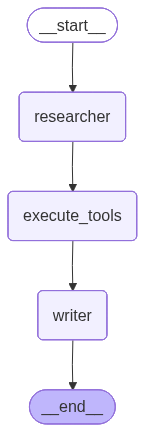

In [53]:
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("execute_tools", execute_tools)
workflow.add_node("writer", writer_agent)

# Set entry point
workflow.set_entry_point("researcher")

# Define flow (remove duplicate edges)
workflow.add_edge("researcher", "execute_tools")
workflow.add_edge("execute_tools", "writer")
workflow.add_edge("writer", END)

final_workflow = workflow.compile()
final_workflow

In [54]:
response = final_workflow.invoke({
       "messages": [HumanMessage(content="Research about the usecase of agentic ai in business")]
   })

In [55]:
response["messages"][-1].content

'Agentic AI offers numerous business applications. Key use cases include:\n\n*   **Healthcare:** AI agents can proactively analyze data to assist in diagnostics, manage drug processes, and monitor patient vitals in real-time, flagging potential health risks.\n*   **Retail:** They personalize shopping experiences through product recommendations, trend prediction, inventory management, and powering customer service chatbots. In brick-and-mortar stores, they can scan shelves and manage inventory in real-time, boosting sales and customer satisfaction.\n*   **Sales:** Automating tasks and streamlining access to customer data.\n*   **Banking:** Reinventing processes such as creating credit-risk memos.\n*   **General:** Streamlining access to customer data, automating tasks.\n\nTo maximize the impact of agentic AI, businesses should focus on strategic programs, business processes, cross-functional teams, and scalable delivery rather than scattered initiatives and siloed experimentation.'

### Supervisor Multi Agent AI

In [58]:
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime

In [60]:

class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    next_agent: str = ""
    research_data: str = ""
    analysis: str = ""
    final_report: str = ""
    task_complete: bool = False
    current_task: str = ""

In [61]:
from langchain_core.prompts import ChatPromptTemplate
def create_supervisor_chain():
    """Creates the supervisor decision chain"""
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
1. Researcher - Gathers information and data
2. Analyst - Analyzes data and provides insights  
3. Writer - Creates reports and summaries

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has research data: {has_research}
- Has analysis: {has_analysis}
- Has report: {has_report}

Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
"""),
        ("human", "{task}")
    ])
    
    return supervisor_prompt | llm


In [62]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using Groq LLM"""
    
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    
    # Check what's been completed
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))
    
    # Get LLM decision
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })
    
    # Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)
    
    # Determine next agent
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: All tasks complete! Great work team."
    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "📋 Supervisor: Let's start with research. Assigning to Researcher..."
    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "📋 Supervisor: Research done. Time for analysis. Assigning to Analyst..."
    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "📋 Supervisor: Analysis complete. Let's create the report. Assigning to Writer..."
    else:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: Task seems complete."
    
    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

In [63]:


# ===================================
# Agent 1: Researcher 
# ===================================

def researcher_agent(state: SupervisorState) -> Dict:
    """Researcher uses Gemini to gather information"""
    
    task = state.get("current_task", "research topic")
    
    # Create research prompt
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""
    
    # Get research from LLM
    research_response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = research_response.content
    
    # Create agent message
    agent_message = f"🔍 Researcher: I've completed the research on '{task}'.\n\nKey findings:\n{research_data[:500]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": research_data,
        "next_agent": "supervisor"
    }

In [64]:
# ===================================
# Agent 2: Analyst (using Gemini)
# ===================================

def analyst_agent(state: SupervisorState) -> Dict:
    """Analyst uses Gemini to analyze the research"""
    
    research_data = state.get("research_data", "")
    task = state.get("current_task", "")
    
    # Create analysis prompt
    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

Research Data:
{research_data}

Provide:
1. Key insights and patterns
2. Strategic implications
3. Risks and opportunities
4. Recommendations

Focus on actionable insights related to: {task}"""
    
    # Get analysis from LLM
    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis = analysis_response.content
    
    # Create agent message
    agent_message = f"📊 Analyst: I've completed the analysis.\n\nTop insights:\n{analysis[:400]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }


In [ ]:
# ===================================
# Agent 3: Writer (using Gemini)
# ===================================

def writer_agent(state: SupervisorState) -> Dict:
    """Writer uses Gemini to create final report"""
    
    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")
    
    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings  
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""
    
    # Get report from LLM
    report_response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = report_response.content
    
    # Create final formatted report
    final_report = f"""
📄 FINAL REPORT
{'='*50}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Topic: {task}
{'='*50}

{report}

{'='*50}
Report compiled by Multi-Agent AI System powered by Groq
"""
    
    return {
        "messages": [AIMessage(content=f"✍️ Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [66]:
# ===================================
# Router Function
# ===================================

def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """Routes to next agent based on state"""
    
    next_agent = state.get("next_agent", "supervisor")
    
    if next_agent == "end" or state.get("task_complete", False):
        return END
        
    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent
        
    return "supervisor"

In [67]:
# Create workflow
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)

# Set entry point
workflow.set_entry_point("supervisor")

# Add routing
for node in ["supervisor", "researcher", "analyst", "writer"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            END: END
        }
    )

graph=workflow.compile()

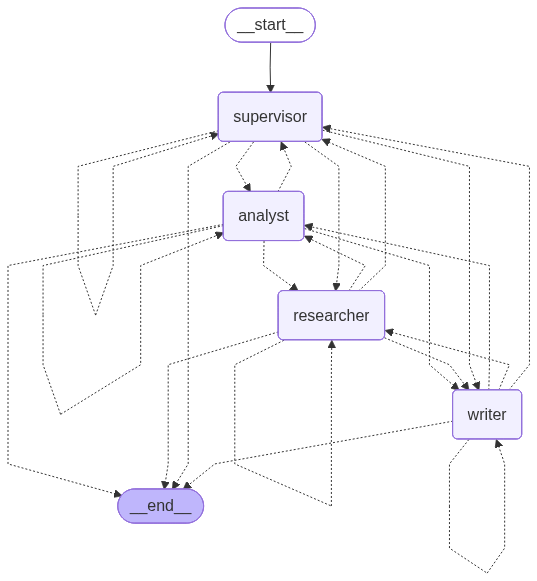

In [68]:
graph

In [71]:
response = graph.invoke({
    "messages": [HumanMessage(content="What are the benefits and risks of AI in healthcare?")]
})

researcher
analyst
writer


In [72]:
response['final_report']

"\n📄 FINAL REPORT\n==================================================\nGenerated: 2025-10-14 14:33\nTopic: 📊 Analyst: I've completed the analysis.\n\nTop insights:\nOkay, here's an analysis of the provided research data on AI in Healthcare, focusing on actionable insights, strategic implications, risks, opportunities, and recommendations.\n\n**1. Key Insights and Patterns**\n\n*   **Significant Market Growth:** The AI in healthcare market is experiencing explosive growth, indicating strong investor interest and increasing adoption.  The projected CAGR of 38.6% is...\n==================================================\n\n## Executive Report: AI in Healthcare - Strategic Analysis and Recommendations\n\n**Date:** October 26, 2023\n\n**Prepared for:** Executive Leadership\n\n**1. Executive Summary**\n\nThis report analyzes the current landscape of Artificial Intelligence (AI) in healthcare, highlighting key benefits, risks, and strategic implications. The AI in healthcare market is experie

## Now we'll try hierarchy  

### We'll see if a task comes it'll be as such:

### - CEO
#### - Research Team Leader -> Data Researcher or Market Researcher
#### - Writing Team Leader -> Technical Writer or Summary Writer